In [6]:
import torch 
import torch.nn as nn 
import torch.optim as optim 
from torch.utils.data import DataLoader 
import matplotlib.pyplot as plt 
import numpy as np
import pandas as pd

In [7]:
df = pd.read_csv('Raw_set6.csv')
df.head()
df = df[
    (df['Frequency.valid'] == 1) & 
    (df['PW.Valid'] == 1) & 
    (df['Power.valid'] == 1)
]
df.shape

(27488, 33)

In [8]:
print(df.columns)

Index(['MessageTOD', 'Fused_TOD', 'IST', 'TOA(sec)', 'TOA(msec)',
       'SourceIndex', 'Pulse.Saturation', 'Frequency.valid', 'Pre.Look.flag',
       'Blank.accured', 'PD.type', 'Frequency(MHz)', 'Power ', 'Power.valid',
       'Receiver.ID', 'Freq..&.AMP.avg', 'Antenna.Code', 'Association.Dis',
       'Azimuth(deg)', 'Elevation/ANT.Power.2', 'Azimuth.valid',
       'Elavetion.valid', 'DF.accuracy', 'ANT.Power.1', 'Phase.1.valid',
       'Phase.2.valid', 'Phase.1.value', 'Phase.2.value', 'PW(usec)',
       'PW.Valid', 'Mission.no/Tracker.code', 'Tracker.window.S.N.',
       'Tracker/Mission.flag'],
      dtype='object')


In [9]:
df=df[['Frequency(MHz)','Power ','PW(usec)','Azimuth(deg)','TOA(msec)']]
df.rename(columns={
    'Frequency(MHz)': 'Frequency',
    'Power ': 'Amplitude',  # Note: Be careful with the space in 'Power '
    'PW(usec)': 'PulseWidth',
    'Azimuth(deg)': 'AOA',
    'TOA(msec)':'TOA'
}, inplace=True)

In [10]:
df.to_csv('S6data.csv',index=False)

In [24]:
df_new=pd.read_csv('cleaned.csv')
df_new.shape

(21573, 5)

In [25]:
from sklearn.preprocessing import MinMaxScaler

# New cell to load and normalize CSV data

df = df[['Frequency', 'PulseWidth', 'Amplitude', 'AOA']]
# df=df.sort_values(by="TOA")
# Normalize each column to [0, 1] using min-max normalization
scaler = MinMaxScaler()
df_norm = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)
data_tensor = torch.tensor(df_norm.values, dtype=torch.float32)
dataset = torch.utils.data.TensorDataset(data_tensor)
batch_size = 128
data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [26]:
# Planar normalizing flow layer
class PlanarFlow(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.u = nn.Parameter(torch.randn(1, dim))
        self.w = nn.Parameter(torch.randn(1, dim))
        self.b = nn.Parameter(torch.zeros(1))
    def forward(self, z):
        linear = z @ self.w.t() + self.b        # (B,1)
        z_new = z + self.u * torch.tanh(linear)  # (B,dim)
        psi = (1 - torch.tanh(linear)**2) * self.w  # (B,dim)
        det = 1 + psi @ self.u.t()               # (B,1)
        log_abs_det = torch.log(det.abs() + 1e-8).squeeze(-1)
        return z_new, log_abs_det

# Encoder with extra layer
class Encoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim*2)
        self.bn1 = nn.BatchNorm1d(hidden_dim*2)
        self.fc2 = nn.Linear(hidden_dim*2, hidden_dim)
        self.bn2 = nn.BatchNorm1d(hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, hidden_dim)
        self.bn3 = nn.BatchNorm1d(hidden_dim)
        self.fc_mu = nn.Linear(hidden_dim, latent_dim)
        self.fc_logvar = nn.Linear(hidden_dim, latent_dim)
        self.dropout = nn.Dropout(0.1)
    def forward(self, x):
        h = torch.relu(self.bn1(self.fc1(x)))
        h = self.dropout(h)
        h = torch.relu(self.bn2(self.fc2(h)))
        h = self.dropout(h)
        h = torch.relu(self.bn3(self.fc3(h)))
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        return mu, logvar

# Decoder unchanged
class Decoder(nn.Module):
    def __init__(self, latent_dim, hidden_dim, output_dim):
        super().__init__()
        self.fc1 = nn.Linear(latent_dim, hidden_dim)
        self.bn1 = nn.BatchNorm1d(hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim*2)
        self.bn2 = nn.BatchNorm1d(hidden_dim*2)
        self.fc3 = nn.Linear(hidden_dim*2, output_dim)
        self.dropout = nn.Dropout(0.1)
    def forward(self, z):
        h = torch.relu(self.bn1(self.fc1(z)))
        h = self.dropout(h)
        h = torch.relu(self.bn2(self.fc2(h)))
        h = self.dropout(h)
        return torch.sigmoid(self.fc3(h))

# VAE with flows
class VAE(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim, n_flows=4):
        super().__init__()
        self.encoder = Encoder(input_dim, hidden_dim, latent_dim)
        self.decoder = Decoder(latent_dim, hidden_dim, input_dim)
        self.flows = nn.ModuleList([PlanarFlow(latent_dim) for _ in range(n_flows)])
    def forward(self, x):
        mu, logvar = self.encoder(x)
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        z0 = mu + eps * std
        sum_log_det = 0
        z = z0
        for flow in self.flows:
            z, log_det = flow(z)
            sum_log_det += log_det
        x_hat = self.decoder(z)
        return x_hat, mu, logvar, z0, sum_log_det



In [27]:
# def loss_function(x, x_hat, mu, logvar, beta=1.0):
#     BCE = nn.functional.binary_cross_entropy(x_hat, x, reduction='sum')
#     KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
#     return BCE + beta * KLD

def loss_function(x, x_hat, mu, logvar, beta=1.0):
    # Use mean squared error for reconstruction loss
    MSE = nn.functional.mse_loss(x_hat, x, reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return MSE + beta * KLD

In [29]:
!pip install optuna

Defaulting to user installation because normal site-packages is not writeable
  Using cached optuna-4.4.0-py3-none-any.whl (395 kB)
  Using cached sqlalchemy-2.0.41-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (3.2 MB)
  Using cached alembic-1.16.2-py3-none-any.whl (242 kB)
  Using cached colorlog-6.9.0-py3-none-any.whl (11 kB)
  Using cached tomli-2.2.1-py3-none-any.whl (14 kB)
  Using cached greenlet-3.2.3-cp310-cp310-manylinux_2_24_x86_64.manylinux_2_28_x86_64.whl (582 kB)


In [30]:
import optuna
from sklearn.model_selection import train_test_split

def objective(trial):
    # Suggest hyperparameters
    hidden_dim = trial.suggest_int("hidden_dim", 10, 50)
    latent_dim = trial.suggest_int("latent_dim", 2, 10)
    lr = trial.suggest_loguniform("lr", 1e-4, 1e-2)
    epochs = trial.suggest_int("epochs", 50, 150)

    input_dim = 4
    
    # Split dataset into training and validation sets
    indices = list(range(len(dataset)))
    train_idx, valid_idx = train_test_split(indices, test_size=0.2, random_state=42)
    train_subset = torch.utils.data.Subset(dataset, train_idx)
    valid_subset = torch.utils.data.Subset(dataset, valid_idx)
    train_loader = DataLoader(train_subset, batch_size=128, shuffle=True)
    valid_loader = DataLoader(valid_subset, batch_size=128, shuffle=False)
    
    # Instantiate the model, loss and optimizer
    vae_model = VAE(input_dim, hidden_dim, latent_dim)
    optimizer = optim.Adam(vae_model.parameters(), lr=lr)

    # Training loop on training set
    vae_model.train()
    for epoch in range(epochs):
        train_loss = 0
        for (x_batch,) in train_loader:
            optimizer.zero_grad()
            x_hat, mu, logvar, _, _ = vae_model(x_batch)
            loss = loss_function(x_batch, x_hat, mu, logvar)
            loss.backward()
            train_loss += loss.item()
            optimizer.step()
    
    # Validation loss after training
    vae_model.eval()
    valid_loss = 0
    with torch.no_grad():
        for (x_batch,) in valid_loader:
            x_hat, mu, logvar, _, _ = vae_model(x_batch)
            loss = loss_function(x_batch, x_hat, mu, logvar)
            valid_loss += loss.item()
    avg_valid_loss = valid_loss / len(valid_subset)
    return avg_valid_loss

study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=30)
print("Best trial:")
trial = study.best_trial
print(f"  Loss: {trial.value}")
print("  Hyperparameters:")
for key, value in trial.params.items():
    print(f"    {key}: {value}")

/home/harshwardhan/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[I 2025-06-23 12:36:43,683] A new study created in memory with name: no-name-1652c781-6352-4e11-82dd-40e24c096bab


/tmp/ipykernel_353790/1611913400.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform("lr", 1e-4, 1e-2)
[I 2025-06-23 12:38:03,113] Trial 0 finished with value: 0.0854956759414312 and parameters: {'hidden_dim': 10, 'latent_dim': 4, 'lr': 0.002289777922129263, 'epochs': 109}. Best is trial 0 with value: 0.0854956759414312.
/tmp/ipykernel_353790/1611913400.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform("lr", 1e-4, 1e-2)
[I 2025-06-23 12:39:10,064] Trial 1 finished with value: 0.08545828438013325 and parameters: {'hidden_dim': 34, 'latent_dim': 5, 'lr': 0.004018135884700052, 'epochs': 80}. Best is trial 1 with

Best trial:
  Loss: 0.0854108261602408
  Hyperparameters:
    hidden_dim: 45
    latent_dim: 4
    lr: 0.005868953273670491
    epochs: 125


In [ ]:
# Modified visualization cell for CSV data
# First define the necessary model and latent_dim using the best trial hyperparameters
input_dim = 4
hidden_dim = trial.params["hidden_dim"]
latent_dim = trial.params["latent_dim"]
vae = VAE(input_dim, hidden_dim, latent_dim)
# Optionally, load the trained model weights:
# vae.load_state_dict(torch.load("path_to_trained_model.pth"))

vae.eval()
with torch.no_grad():
    # Grab a batch of original data
    (x_batch,) = next(iter(data_loader))
    x_hat, _, _ = vae(x_batch)
    print("Original data (first 5 samples):")
    print(x_batch[:5])
    print("\nReconstructed data (first 5 samples):")
    print(x_hat[:5])
    
# Generating new synthetic samples from random latent vectors
with torch.no_grad():
    z = torch.randn(10, latent_dim)
    generated_samples = vae.decoder(z)
    print("\nGenerated new samples:")
    print(generated_samples)

ValueError: too many values to unpack (expected 3)

In [ ]:
N = 2000  # change N to desired number of samples
z = torch.randn(N, latent_dim)
generated_samples = vae.decoder(z)

In [ ]:
import pandas as pd

df_generated = pd.DataFrame(generated_samples.detach().numpy(), columns=["Frequency", "PulseWidth", "Amplitude", "AOA"])
df_generated.to_csv("generated_samples.csv", index=False)

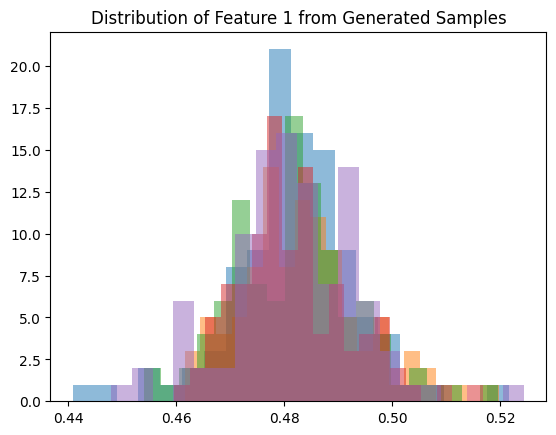

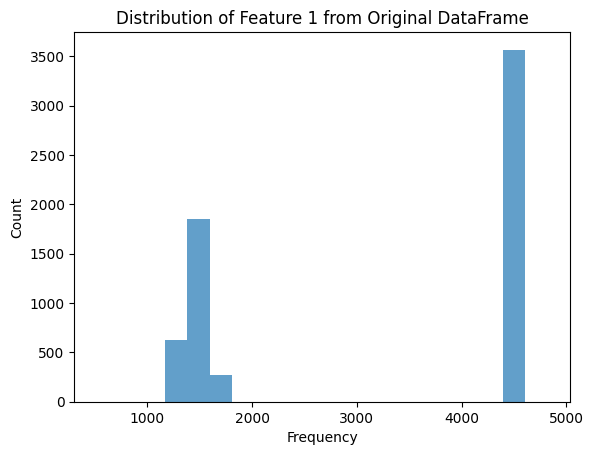

In [ ]:
import matplotlib.pyplot as plt

# Generate multiple sets of samples
samples_list = [vae.decoder(torch.randn(100, latent_dim)).detach().numpy() for _ in range(5)]
# Plot histogram for feature 1 from each set
for samples in samples_list:
    plt.hist(samples[:, 0], alpha=0.5, bins=20)
plt.title("Distribution of Feature 1 from Generated Samples")
plt.show()
plt.hist(df['Frequency'], alpha=0.7, bins=20)
plt.title("Distribution of Feature 1 from Original DataFrame")
plt.xlabel("Frequency")
plt.ylabel("Count")
plt.show()

In [ ]:
def unnormalize_generated(df_generated, df):
    # Unnormalize TOA using actual min and max from df

    # Unnormalize PulseWidth using actual min and max from df
    pw_min = df['PulseWidth'].min()
    pw_max = df['PulseWidth'].max()
    df_generated['PulseWidth'] = df_generated['PulseWidth'] * (pw_max - pw_min) + pw_min

    # Unnormalize Amplitude using actual min and max from df
    amp_min = df['Amplitude'].min()
    amp_max = df['Amplitude'].max()
    df_generated['Amplitude'] = df_generated['Amplitude'] * (amp_max - amp_min) + amp_min

    # Unnormalize Frequency using actual min and max from df
    freq_min = df['Frequency'].min()
    freq_max = df['Frequency'].max()
    df_generated['Frequency'] = df_generated['Frequency'] * (freq_max - freq_min) + freq_min

    # Unnormalize AOA using actual min and max from df
    aoa_min = df['AOA'].min()
    aoa_max = df['AOA'].max()
    df_generated['AOA'] = df_generated['AOA'] * (aoa_max - aoa_min) + aoa_min

    return df_generated

# Example usage:
# Assuming df is your original DataFrame loaded in the data loading cell and 
# df_generated contains the normalized generated samples.
unnormalized_df = unnormalize_generated(df_generated.copy(), df)
print(unnormalized_df.head())


     Frequency  PulseWidth  Amplitude         AOA
0  2628.239502  137.941635 -34.295574  213.689407
1  2608.621826  150.424652 -32.164520  204.527054
2  2726.442871  149.440063 -30.299599  218.876144
3  2629.671631  153.658478 -29.123093  198.455475
4  2632.104248  152.065521 -26.849194  193.441406


In [ ]:
unnormalized_df.to_csv('generated_df.csv',index=False)

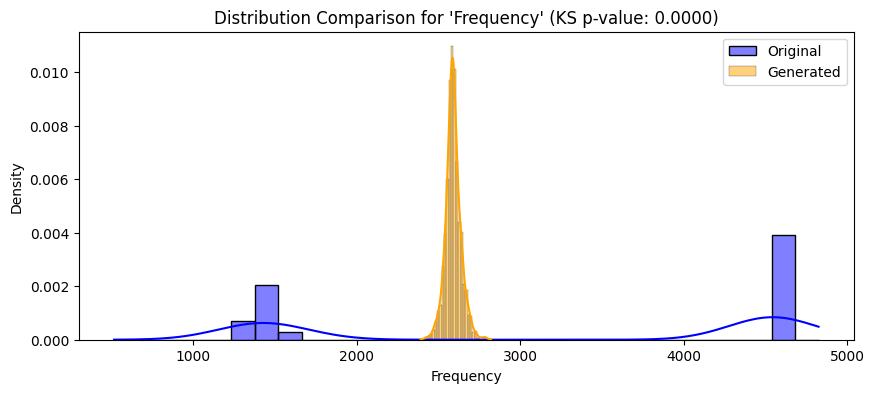

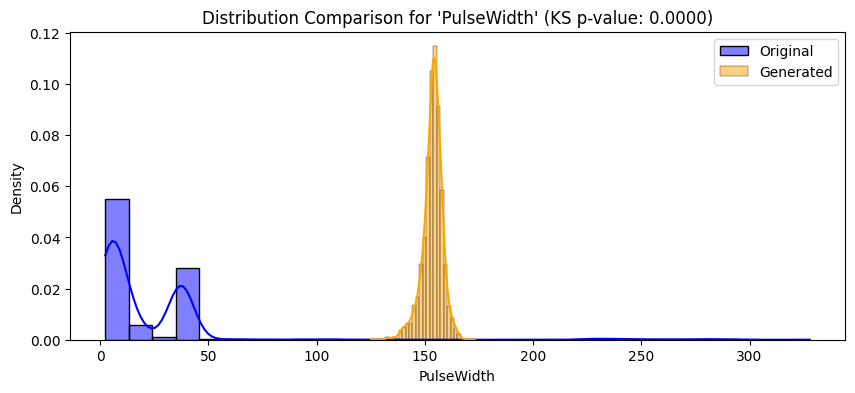

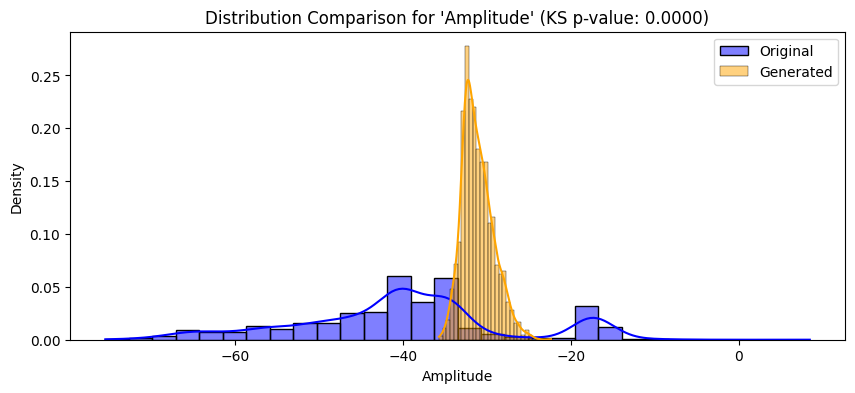

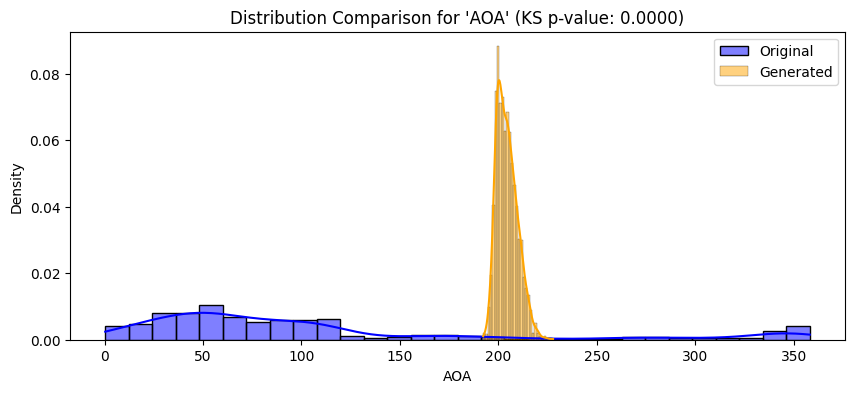

In [ ]:
import seaborn as sns
from scipy.stats import ks_2samp

import matplotlib.pyplot as plt

# Compare distributions for each column using histograms and the KS test
for col in df.columns:
    plt.figure(figsize=(10, 4))
    # KS test between original and unnormalized generated data
    stat, p_value = ks_2samp(df[col], unnormalized_df[col])
    
    # Overlay histograms with kernel density estimates
    sns.histplot(df[col], bins=30, kde=True, color='blue', label='Original', stat='density', alpha=0.5)
    sns.histplot(unnormalized_df[col], bins=30, kde=True, color='orange', label='Generated', stat='density', alpha=0.5)
    
    plt.title(f"Distribution Comparison for '{col}' (KS p-value: {p_value:.4f})")
    plt.xlabel(col)
    plt.ylabel("Density")
    plt.legend()
    plt.show()